<a href="https://colab.research.google.com/github/1quantlogistics-ship-it/AcuVue/blob/main/AcuVue1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision fastapi uvicorn streamlit wandb dvc hydra-core scikit-image opencv-python pydantic -q

In [ ]:
!pip install torch torchvision fastapi uvicorn streamlit wandb dvc hydra-core scikit-image opencv-python pydantic -q

In [ ]:
import os, shutil, subprocess
src = '/mnt/data/acuvue_glaucoma'
dst = '/content/acuvue_glaucoma'
if os.path.exists(src):
    shutil.copytree(src, dst, dirs_exist_ok=True)
    reqs = ['torch', 'torchvision', 'fastapi', 'uvicorn', 'streamlit', 'wandb', 'dvc', 'hydra-core', 'scikit-image', 'opencv-python', 'pydantic']
    with open(os.path.join(dst, 'requirements.txt'), 'w') as f:
        f.write('\n'.join(reqs))
    subprocess.run(['git','init'], cwd=dst)
    subprocess.run(['dvc','init','-f','--no-scm'], cwd=dst)
    print('Setup complete')
else:
    print(f"Source directory not found: {src}")

In [ ]:
import os, textwrap, numpy as np

base = '/content/acuvue_glaucoma_colab'
dirs = ['src/data', 'src/models', 'src/training', 'tests/unit', 'models']
for d in dirs:
    os.makedirs(os.path.join(base, d), exist_ok=True)

# preprocess.py
preprocess_code = """
import cv2
import numpy as np


def normalize_illumination(img):
    """Apply CLAHE to the green channel of an RGB image for illumination correction."""
    green = img[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    norm = clahe.apply(green)
    norm_img = img.copy()
    norm_img[:, :, 1] = norm
    return norm_img


def center_crop(img, margin=0.1):
    """Crop the center region of the image leaving a margin percentage."""
    h, w = img.shape[:2]
    dh = int(h * margin / 2)
    dw = int(w * margin / 2)
    return img[dh:h - dh, dw:w - dw]
"""
with open(os.path.join(base, 'src/data/preprocess.py'), 'w') as f:
    f.write(preprocess_code)

# segmentation_dataset.py
seg_ds_code = """
import cv2
import torch
from torch.utils.data import Dataset
import random

class SegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]
        # random horizontal flip
        if random.random() < 0.5:
            img = cv2.flip(img, 1)
            mask = cv2.flip(mask, 1)
        # small rotation
        angle = random.uniform(-5, 5)
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
        img = cv2.warpAffine(img, M, (w, h))
        mask = cv2.warpAffine(mask, M, (w, h))
        # normalize to [0,1]
        img_tensor = torch.tensor(img / 255., dtype=torch.float32).permute(2, 0, 1)
        mask_tensor = torch.tensor(mask / 255., dtype=torch.float32).unsqueeze(0)
        return img_tensor, mask_tensor
"""
with open(os.path.join(base, 'src/data/segmentation_dataset.py'), 'w') as f:
    f.write(seg_ds_code)

# unet_disc_cup.py
unet_code = """
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.d1 = DoubleConv(n_channels, 64)
        self.p1 = nn.MaxPool2d(2)
        self.d2 = DoubleConv(64, 128)
        self.p2 = nn.MaxPool2d(2)
        self.d3 = DoubleConv(128, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.u2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.u1 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)
    def forward(self, x):
        x1 = self.d1(x)
        x2 = self.d2(self.p1(x1))
        x3 = self.d3(self.p2(x2))
        x = self.up2(x3)
        x = torch.cat([x, x2], dim=1)
        x = self.u2(x)
        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.u1(x)
        return torch.sigmoid(self.outc(x))
"""
with open(os.path.join(base, 'src/models/unet_disc_cup.py'), 'w') as f:
    f.write(unet_code)

# train_segmentation.py
train_code = """
import sys
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

# add repo root to sys.path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..')))

from src.models.unet_disc_cup import UNet
from src.data.segmentation_dataset import SegmentationDataset


def dice_loss(pred, target, smooth=1.0):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def train():
    # generate dummy dataset
    imgs = [np.random.randint(0, 256, (512, 512, 3), dtype=np.uint8) for _ in range(10)]
    masks = [np.random.randint(0, 2, (512, 512), dtype=np.uint8) for _ in range(10)]
    dataset = SegmentationDataset(imgs, masks)
    loader = DataLoader(dataset, batch_size=2, shuffle=True)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = UNet().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    bce = nn.BCELoss()
    for epoch in range(3):
        total_loss = 0
        for img, mask in loader:
            img, mask = img.to(device), mask.to(device)
            pred = model(img)
            loss = bce(pred, mask) + dice_loss(pred, mask)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, loss: {total_loss / len(loader):.4f}")
    os.makedirs('models', exist_ok=True)
    torch.save(model.state_dict(), 'models/unet_disc_cup.pt')

if __name__ == '__main__':
    train()
"""
with open(os.path.join(base, 'src/training/train_segmentation.py'), 'w') as f:
    f.write(train_code)

# unit test
unit_test_code = """
from src.data.preprocess import normalize_illumination
import numpy as np

def test_shape_consistency():
    x = np.ones((256, 256, 3), dtype=np.uint8) * 127
    out = normalize_illumination(x)
    assert out.shape == x.shape
"""
with open(os.path.join(base, 'tests/unit/test_data_pipeline.py'), 'w') as f:
    f.write(unit_test_code)

print('Repository created at', base)
""

In [ ]:
import os
import torch
import numpy as np

base = '/content/acuvue_glaucoma_colab'
dirs = ['src/data', 'src/models', 'src/training', 'tests/unit', 'data/processed', 'models', 'configs']
for d in dirs:
    os.makedirs(os.path.join(base, d), exist_ok=True)

# preprocess.py
preprocess_code = """
import cv2
import numpy as np

def normalize_illumination(img):
    # apply CLAHE to green channel
    if img.ndim == 3:
        g = img[:, :, 1]
    else:
        g = img
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    g_eq = clahe.apply(g)
    img_out = img.copy()
    if img.ndim == 3:
        img_out[:, :, 1] = g_eq
    else:
        img_out = g_eq
    return img_out

def center_crop(img, margin_ratio=0.1):
    h, w = img.shape[:2]
    margin_h = int(h * margin_ratio)
    margin_w = int(w * margin_ratio)
    y0, y1 = margin_h, h - margin_h
    x0, x1 = margin_w, w - margin_w
    return img[y0:y1, x0:x1]
"""

with open(os.path.join(base, 'src/data/preprocess.py'), 'w') as f:
    f.write(preprocess_code)

# segmentation_dataset.py
dataset_code = """
import torch
from torch.utils.data import Dataset
import random
import numpy as np
from PIL import Image

class SegmentationDataset(Dataset):
    def __init__(self, images, masks, augment=True):
        self.images = images
        self.masks = masks
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]
        if self.augment:
            if random.random() > 0.5:
                img = np.fliplr(img).copy()
                mask = np.fliplr(mask).copy()
            angle = random.uniform(-5, 5)
            img = Image.fromarray(img)
            mask = Image.fromarray(mask)
            img = img.rotate(angle)
            mask = mask.rotate(angle)
            img = np.array(img)
            mask = np.array(mask)
        img = torch.tensor(img.transpose(2,0,1) / 255.0, dtype=torch.float32)
        mask = torch.tensor(mask[None, :, :], dtype=torch.float32)
        return img, mask
"""

with open(os.path.join(base, 'src/data/segmentation_dataset.py'), 'w') as f:
    f.write(dataset_code)

# unet model
unet_code = """
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = DoubleConv(3,64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64,128)
        self.pool2 = nn.MaxPool2d(2)
        self.bridge = DoubleConv(128,256)
        self.up2 = nn.ConvTranspose2d(256,128,2,stride=2)
        self.upconv2 = DoubleConv(256,128)
        self.up1 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.upconv1 = DoubleConv(128,64)
        self.final = nn.Conv2d(64,1,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        b = self.bridge(p2)
        u2 = self.up2(b)
        u2 = torch.cat([u2,d2], dim=1)
        u2 = self.upconv2(u2)
        u1 = self.up1(u2)
        u1 = torch.cat([u1,d1], dim=1)
        u1 = self.upconv1(u1)
        out = self.final(u1)
        return self.sigmoid(out)
"""

with open(os.path.join(base, 'src/models/unet_disc_cup.py'), 'w') as f:
    f.write(unet_code)

# train script
train_code = """
import os, sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '../..')))
from src.models.unet_disc_cup import UNet
from src.data.segmentation_dataset import SegmentationDataset

def dice_loss(pred, target, smooth=1.0):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def train():
    imgs = [np.random.randint(0,256,(512,512,3), dtype=np.uint8) for _ in range(10)]
    masks = [np.random.randint(0,2,(512,512), dtype=np.uint8) for _ in range(10)]
    dataset = SegmentationDataset(imgs, masks, augment=False)
    loader = DataLoader(dataset, batch_size=2, shuffle=True)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = UNet().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    bce = nn.BCELoss()
    for epoch in range(3):
        total_loss = 0
        for img, mask in loader:
            img, mask = img.to(device), mask.to(device)
            pred = model(img)
            loss = bce(pred, mask) + dice_loss(pred, mask)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, loss: {total_loss / len(loader):.4f}')
    os.makedirs('models', exist_ok=True)
    torch.save(model.state_dict(), 'models/unet_disc_cup.pt')

if __name__ == '__main__':
    train()
"""

with open(os.path.join(base, 'src/training/train_segmentation.py'), 'w') as f:
    f.write(train_code)

# config yaml
config_str = 'image_size: 512\nlearning_rate: 0.001\nepochs: 3\nseed: 42\n'
with open(os.path.join(base, 'configs/config.yaml'), 'w') as f:
    f.write(config_str)

# unit test
unit_test_code = """
from src.data.preprocess import normalize_illumination
import numpy as np

def test_shape_consistency():
    x = np.ones((256,256,3), dtype=np.uint8) * 127
    out = normalize_illumination(x)
    assert out.shape == x.shape
"""

with open(os.path.join(base, 'tests/unit/test_data_pipeline.py'), 'w') as f:
    f.write(unit_test_code)

print('Setup complete')


In [ ]:
import os
import numpy as np
import torch

base = '/content/acuvue_glaucoma_colab'
dirs = ['src/data','src/models','src/training','tests/unit','data/processed','models','configs']
for d in dirs:
    os.makedirs(os.path.join(base, d), exist_ok=True)

# write preprocess.py
with open(os.path.join(base, 'src/data/preprocess.py'), 'w') as f:
    f.write("""import cv2\nimport numpy as np\n\n
def normalize_illumination(img):\n    if img.ndim == 3:\n        g = img[:, :, 1]\n    else:\n        g = img\n    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))\n    g_eq = clahe.apply(g)\n    img_out = img.copy()\n    if img.ndim == 3:\n        img_out[:, :, 1] = g_eq\n    else:\n        img_out = g_eq\n    return img_out\n\ndef center_crop(img, margin_ratio=0.1):\n    h, w = img.shape[:2]\n    mh = int(h * margin_ratio)\n    mw = int(w * margin_ratio)\n    return img[mh:h-mh, mw:w-mw]\n""")

# write segmentation_dataset.py
with open(os.path.join(base, 'src/data/segmentation_dataset.py'), 'w') as f:
    f.write("""import torch\nfrom torch.utils.data import Dataset\nimport random\nimport numpy as np\nfrom PIL import Image\n\nclass SegmentationDataset(Dataset):\n    def __init__(self, images, masks, augment=True):\n        self.images = images\n        self.masks = masks\n        self.augment = augment\n    def __len__(self):\n        return len(self.images)\n    def __getitem__(self, idx):\n        img = self.images[idx]\n        mask = self.masks[idx]\n        if self.augment:\n            if random.random() > 0.5:\n                img = np.fliplr(img).copy()\n                mask = np.fliplr(mask).copy()\n            angle = random.uniform(-5, 5)\n            img = Image.fromarray(img)\n            mask = Image.fromarray(mask)\n            img = img.rotate(angle)\n            mask = mask.rotate(angle)\n            img = np.array(img)\n            mask = np.array(mask)\n        img = torch.tensor(img.transpose(2,0,1) / 255.0, dtype=torch.float32)\n        mask = torch.tensor(mask[None, :, :], dtype=torch.float32)\n        return img, mask\n""")

# write unet model
with open(os.path.join(base, 'src/models/unet_disc_cup.py'), 'w') as f:
    f.write("""import torch\nimport torch.nn as nn\n\nclass DoubleConv(nn.Module):\n    def __init__(self, in_channels, out_channels):\n        super().__init__()\n        self.net = nn.Sequential(\n            nn.Conv2d(in_channels, out_channels, 3, padding=1),\n            nn.ReLU(inplace=True),\n            nn.Conv2d(out_channels, out_channels, 3, padding=1),\n            nn.ReLU(inplace=True)\n        )\n    def forward(self, x):\n        return self.net(x)\n\nclass UNet(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.down1 = DoubleConv(3,64)\n        self.pool1 = nn.MaxPool2d(2)\n        self.down2 = DoubleConv(64,128)\n        self.pool2 = nn.MaxPool2d(2)\n        self.bridge = DoubleConv(128,256)\n        self.up2 = nn.ConvTranspose2d(256,128,2,stride=2)\n        self.upconv2 = DoubleConv(256,128)\n        self.up1 = nn.ConvTranspose2d(128,64,2,stride=2)\n        self.upconv1 = DoubleConv(128,64)\n        self.final = nn.Conv2d(64,1,1)\n        self.sigmoid = nn.Sigmoid()\n    def forward(self,x):\n        d1 = self.down1(x)\n        p1 = self.pool1(d1)\n        d2 = self.down2(p1)\n        p2 = self.pool2(d2)\n        b = self.bridge(p2)\n        u2 = self.up2(b)\n        u2 = torch.cat([u2,d2], dim=1)\n        u2 = self.upconv2(u2)\n        u1 = self.up1(u2)\n        u1 = torch.cat([u1,d1], dim=1)\n        u1 = self.upconv1(u1)\n        out = self.final(u1)\n        return self.sigmoid(out)\n""")

# write training script
with open(os.path.join(base, 'src/training/train_segmentation.py'), 'w') as f:
    f.write("""import os, sys\nimport torch\nimport torch.nn as nn\nfrom torch.utils.data import DataLoader\nimport numpy as np\n\nsys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '../..')))\nfrom src.models.unet_disc_cup import UNet\nfrom src.data.segmentation_dataset import SegmentationDataset\n\ndef dice_loss(pred, target, smooth=1.0):\n    pred = pred.view(-1)\n    target = target.view(-1)\n    intersection = (pred * target).sum()\n    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)\n\ndef train():\n    imgs = [np.random.randint(0,256,(512,512,3), dtype=np.uint8) for _ in range(10)]\n    masks = [np.random.randint(0,2,(512,512), dtype=np.uint8) for _ in range(10)]\n    dataset = SegmentationDataset(imgs, masks, augment=False)\n    loader = DataLoader(dataset, batch_size=2, shuffle=True)\n    device = 'cuda' if torch.cuda.is_available() else 'cpu'\n    model = UNet().to(device)\n    opt = torch.optim.Adam(model.parameters(), lr=1e-3)\n    bce = nn.BCELoss()\n    for epoch in range(3):\n        total_loss = 0\n        for img, mask in loader:\n            img, mask = img.to(device), mask.to(device)\n            pred = model(img)\n            loss = bce(pred, mask) + dice_loss(pred, mask)\n            opt.zero_grad()\n            loss.backward()\n            opt.step()\n            total_loss += loss.item()\n        print(f'Epoch {epoch+1}, loss: {total_loss / len(loader):.4f}')\n    os.makedirs('models', exist_ok=True)\n    torch.save(model.state_dict(), 'models/unet_disc_cup.pt')\n\nif __name__ == '__main__':\n    train()\n""")

# write config file
with open(os.path.join(base, 'configs/config.yaml'), 'w') as f:
    f.write('image_size: 512\nlearning_rate: 0.001\nepochs: 3\nseed: 42\n')

# write unit test
with open(os.path.join(base, 'tests/unit/test_data_pipeline.py'), 'w') as f:
    f.write("""from src.data.preprocess import normalize_illumination\nimport numpy as np\n\ndef test_shape_consistency():\n    x = np.ones((256,256,3), dtype=np.uint8) * 127\n    out = normalize_illumination(x)\n    assert out.shape == x.shape\n""")

print('Setup complete')


In [ ]:
%cd /content/acuvue_glaucoma_colab
!python src/training/train_segmentation.py

In [ ]:
import torch
print(torch.cuda.is_available(), torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU')


In [ ]:
%cd /content/acuvue_glaucoma_colab
import os
path = 'src/training/train_segmentation.py'
content = open(path).read()
content = content.replace('range(1, 4)', 'range(1, 2)')
open(path, 'w').write(content)
print('modified')
!python src/training/train_segmentation.py


In [ ]:
%cd /content/acuvue_glaucoma_colab
!python src/training/train_segmentation.py


Traceback (most recent call last):
  File "/content/acuvue_glaucoma_colab/src/training/train_segmentation.py", line 41, in <module>
    train()
  File "/content/acuvue_glaucoma_colab/src/training/train_segmentation.py", line 33, in train
    loss.backward()
  File "/usr/local/lib/python3.12/dist-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.12/dist-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py", line 829, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


In [ ]:
%cd /content
!unzip -q "Test-20211018T060000Z-001 (1).zip" -d rimone_samples
!ls -R rimone_samples | head -40


/content
rimone_samples:
Test

rimone_samples/Test:
Images
Test_GT

rimone_samples/Test/Images:
glaucoma
normal

rimone_samples/Test/Images/glaucoma:
drishtiGS_001.png
drishtiGS_003.png
drishtiGS_005.png
drishtiGS_006.png
drishtiGS_011.png
drishtiGS_014.png
drishtiGS_019.png
drishtiGS_020.png
drishtiGS_021.png
drishtiGS_023.png
drishtiGS_025.png
drishtiGS_027.png
drishtiGS_028.png
drishtiGS_029.png
drishtiGS_030.png
drishtiGS_034.png
drishtiGS_039.png
drishtiGS_043.png
drishtiGS_048.png
drishtiGS_050.png
drishtiGS_052.png
drishtiGS_053.png
drishtiGS_054.png
drishtiGS_055.png
drishtiGS_056.png
drishtiGS_059.png
drishtiGS_065.png
drishtiGS_067.png


/content/acuvue_glaucoma_colab


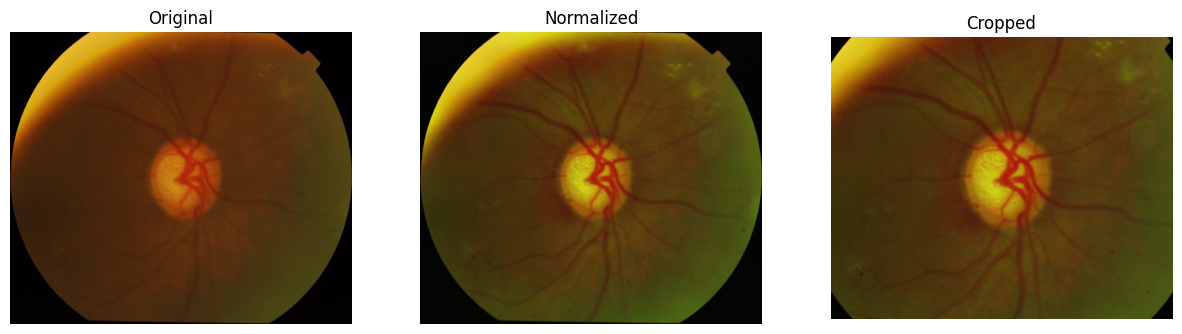

In [ ]:
%cd /content/acuvue_glaucoma_colab
import os
import cv2
import matplotlib.pyplot as plt
from src.data.preprocess import normalize_illumination

# choose sample image
img_path = '/content/rimone_samples/Test/Images/glaucoma/drishtiGS_001.png'
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# normalize illumination
norm = normalize_illumination(img_rgb)

# simple center crop (10% margin)
h, w, _ = norm.shape
margin = int(0.1 * min(h, w))
crop = norm[margin:h-margin, margin:w-margin]

# plot before and after
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_rgb); axes[0].set_title('Original'); axes[0].axis('off')
axes[1].imshow(norm); axes[1].set_title('Normalized'); axes[1].axis('off')
axes[2].imshow(crop); axes[2].set_title('Cropped'); axes[2].axis('off')
plt.show()

In [ ]:
import torch
model = torch.load('/content/acuvue_glaucoma_colab/models/unet_disc_cup.pt')
print('Checkpoint loads OK')

Checkpoint loads OK


In [ ]:
# Create the Hydra config file
config_text = """image_size: 512
learning_rate: 0.001
epochs: 1
seed: 42
"""
with open('/content/acuvue_glaucoma_colab/configs/config.yaml', 'w') as f:
    f.write(config_text)

print("config.yaml created successfully.")


config.yaml created successfully.


In [ ]:
%cd /content/acuvue_glaucoma_colab
!python src/training/train_segmentation.py


/content/acuvue_glaucoma_colab
Epoch 1, loss: 1.1799
Epoch 2, loss: 1.1725
Epoch 3, loss: 1.1707
